# Imports and Constants

In [230]:
lazy_copy = 'labeled_samples_2024-08-09 11/24/00'

import pandas as pd
from tqdm import tqdm
import numpy as np
from datetime import datetime
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import floor
import regex as re
from collections import Counter
from utils import prompt, update_labels, master_path, get_answer_vector, hash_dataframe
import json




mapping = lambda s: {'background': 'context',
                     'future_work': 'context',
                    'differences': 'context',
                     'future work': 'context',
                     'motivation': 'context',
                     'similarities': 'context',
                     'extends': 'uses',
                     '*': 'context'
                     }.get(s) or s

seed = 42 #np.random.randint(0, 100)

# Load existing results

In [231]:

other_path = f'~/Desktop/2. FutureTech/uniform_sample/results/{lazy_copy.replace('/',':')}.csv'

df = pd.read_csv(other_path)
df = df.sort_values(by = 'multisentence').reset_index(drop = True)

df = df.sample(frac=1, random_state = seed)


print(len(df))
df.head()

519


,modelKey,paperId,modelId,multisentence,alex,mc,mc_reduced,mcllmr,mcllm_binary,urop,assignee,strippedModelKey,answer_vector,answer_string,learned_classification
275,1093_adam_(cifar-10),2734fb70be037cd6ab90677d24416c48b6d1bde3,NaN,input video clips of size \(224\times 224\) ar...,uses,NaN,NaN,NaN,NaN,NaN,NaN,adam_(cifar-10),[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0...,"[{""explanation"": ""The sentence mentions 'adam'...",context
93,432_word2vec_(small),682ee9c06f3eff3e3708b4d0419dc85ecf9c6c87,NaN,7 provides a conclusion. ## 2 related work\n\...,background,NaN,NaN,NaN,NaN,NaN,NaN,word2vec_(small),[0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0...,"[{""explanation"": ""The CITING authors mention w...",context
6,1064_bert-large,889c9c37634766b3543424ac6955811f83f260e0,df2b0e26d0599ce3e70df8a9da02e51594e0e992,## 1 introduction\n\nthere have been exciting...,background,background,context,background,background,Background,Selinna,bert-large,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[{""explanation"": ""The CITING authors mention t...",context
167,867_alexnet,b8b02fb31168d53796bf5a8977ab26ee4c004dd5,abd1c342495432171beb7ca8fd9551ef13cbd0ff,"differently, we target at full 4-bit quantizat...",uses,uses,uses,background,uses,Extends,Denis,alexnet,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[{""explanation"": ""The CITING paper mentions th...",context
90,237_resnet-50_billion-scale,0bcca9138d916f6f694e1d89c3db0a74dba6c51a,NaN,3. we conduct sufficient experiments to verify...,similarities,NaN,NaN,NaN,NaN,NaN,NaN,resnet-50_billion-scale,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0...,"[{""explanation"": ""The CITING authors mention a...",context


In [232]:
Counter(df['alex'])

Counter({'background': 265,
         'uses': 111,
         'similarities': 77,
         'extends': 38,
         'differences': 13,
         'motivation': 10,
         '*': 4,
         'future work': 1})

# Parse outputs, generate confusion matrices

In [233]:
background_mask = np.array([1,1,1,1,1,   0,0,0,0,0,   0,0,0,0,0,  1,1])
uses_mask = np.array([0,0,0,0,0,   0,1,1,1,1,   1,1,0,0,0,   0,0])
extends_mask = np.array([0,0,0,0,0,   0,0,0,0,0,   0,0,1,1,0,   0,0])


def get_truth(r, verbose = False, background_mask = background_mask, uses_mask = uses_mask, extends_mask = extends_mask):
    assert(len(background_mask) == len(uses_mask) and len(uses_mask) == len(extends_mask))
    answer_vector = get_answer_vector(r, length = len(background_mask))
    
    if answer_vector is None:
        return None
    
    resolve = lambda mask: np.array([{(0,1):0, (0,0): 0, (0, -1): 1, (1,1):1, (1,0) : 0, (1, -1): 0}[(x,y)] for x,y in zip(answer_vector, mask)]).sum()
    
    background =  resolve(background_mask)
    uses = resolve(uses_mask)
    fine_tune = resolve(extends_mask)

    
    if (verbose):
        print(answer_vector)
        print(f"bg: {background}, uses: {uses}, extends: {fine_tune}", flush = True)
        
    if answer_vector[3]:
        return 'background'

    if fine_tune:
        return 'extends'
    
    if uses:
        return 'uses'
    
    return 'background'

#df['gpt-vector'] = df[label_col].apply(get_truth)
#print(set(df['gpt-vector']))

for idx, row in df.iterrows():
    continue
    if (row['gpt-vector'] is None):
        print(row['multisentence'])
        print(row['gpt-vector'])
        print("\n")

In [234]:
y_label, x_label = 'alex', 'learned_classification'

Labels hash: b'=\xabg\x14\x9c\x88\xa5\xea\x8b2#)\x94Aq0'
Class hash: b'\x1c\xfdE\x814DL\xd8\xef\xa0\x8b\\\x9f\xd3\r\xa3'
{'uses', 'context'} {'uses', 'context'}
Accuracy 0.6994219653179191

Uses false positive: 0.4782608695652174
Uses false negative: 0.7735849056603774

Extends false positive: 0.4782608695652174
Extends false negative: 0.7735849056603774


Text(50.722222222222214, 0.5, 'alex')

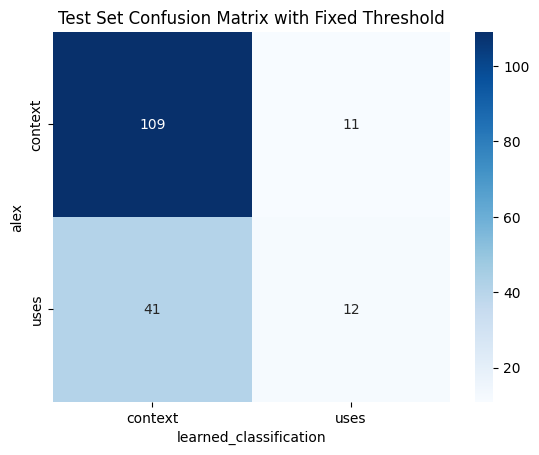

In [235]:
split = floor(2/3 * len(df))
test_mode = True

true = df[y_label][split:] if test_mode else df[y_label][:split]
pred = df[x_label][split:] if test_mode else df[x_label][:split]

print(f"Labels hash: {hash_dataframe(list(true))}")
print(f"Class hash: {hash_dataframe(list(pred))}")


true, pred = list(map(mapping, true)), list(map(mapping, pred))



cm = confusion_matrix(true, pred)
print(set(true), set(pred))
labels = sorted(list({mapping(item) for item in ['background', 'extends', 'uses']}))

diagonal = cm * np.identity(len(labels))
false_positives = (cm - diagonal).sum(axis = 0)/cm.sum(axis = 0)
false_negatives = (cm - diagonal).sum(axis = 1)/cm.sum(axis = 1)
accuracy = diagonal.sum() / cm.sum()

print(f"Accuracy {accuracy}\n")
print(f"Uses false positive: {false_positives[-1]}")
print(f"Uses false negative: {false_negatives[-1]}\n")
print(f"Extends false positive: {false_positives[1]}")
print(f"Extends false negative: {false_negatives[1]}")


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Test Set Confusion Matrix with Fixed Threshold")
plt.xlabel(x_label)
plt.ylabel(y_label)


In [236]:
raise Exception

Exception: 

# Inspect Confusion Matrix
## Get samples, option to relabel

In [ ]:
def get_examples(y_value, x_value):
    mask = (df[y_label].apply(mapping) == y_value) & (df[x_label].apply(mapping) == x_value) 
    return df[mask]

idx = -1
samples = get_examples(y_value='context', x_value = 'uses')
samples.head()

,modelKey,paperId,modelId,multisentence,alex,mc,mc_reduced,mcllmr,mcllm_binary,urop,assignee,strippedModelKey,answer_vector,answer_string,learned_classification
2,582_bart-large,9e06248853f41ab547814fed70e640eba44764cf,395de0bd3837fdf4b4b5e5f04835bcc69c279481,"in this work, we focus on the task of evaluati...",background,extends,extends,differences,context,Uses,Selinna,bart-large,[0.9 0.9 0.8 0.4 0.8 0.6 0.2 0.9 0.8 ...,"[{""explanation"": ""The CITING paper mentions us...",uses
20,266_retinanet-r50,13e00df54d82cebee2b9f76d346e47304f4c7308,NaN,"in the figure, our gated slices are color-code...",background,NaN,NaN,NaN,NaN,NaN,NaN,retinanet-r50,[0.8 0.8 0.8 0.2 0.9 0.4 0.2 0.6 0.3 ...,"[{""explanation"": ""The CITING paper mentions th...",uses
114,120_mobilenet,74487ea7c7a27a1a45c5a4dc306aea47cef0238d,NaN,9: learned data processing aims to learn a pol...,background,NaN,NaN,NaN,NaN,NaN,NaN,mobilenet,[0.4 0.4 0.4 0.4 0.4 0.4 0.3 0.4 0.4 ...,"[{""explanation"": ""The CITING paper mentions th...",uses
168,1064_bert-large,710b37f5b26669e08517bdfc616e700cd67cea1a,df2b0e26d0599ce3e70df8a9da02e51594e0e992,next let us define the relative stock price mo...,background,uses,uses,background,uses,Extends,Selinna,bert-large,[0.9 0.9 0.8 0.6 0.4 0.4 0.4 0.9 0.6 ...,"[{""explanation"": ""The CITING paper mentions th...",uses
174,852_t5-3b,a8fd9c1625011741f74401ff9bdc1c584e25c86d,NaN,clark et al (2020) introduce the replaced toke...,background,NaN,NaN,NaN,NaN,NaN,NaN,t5-3b,[0.9 0.8 0.4 0.3 0.4 0.6 0.2 0.3 0.4 ...,"[{""explanation"": ""The CITING paper mentions th...",uses


In [ ]:
index = samples.index[idx]
print(idx, index)
print(f"Drawing from {len(samples)} samples")
print(samples['modelKey'].iloc[idx])

print(samples['multisentence'].iloc[idx])

vector = [float(el) for el in samples['answer_vector'].iloc[idx][1:-1].split(' ')]
print(vector)
one_indices = [i for i in range(len(vector)) if vector[i] == 1]
one_idx = 1
print(one_indices[one_idx], json.loads(samples['answer_string'].iloc[idx])[one_indices[one_idx]])

print(samples[y_label].iloc[idx])
print(samples[x_label].iloc[idx])

-1 487
Drawing from 26 samples
103_r-cnn_(t-net)
#### 4.2.1 bounding-box-like object detectors

the most popular architectures for 2d object detection in images are single stage and double stage detectors. popular single stage detectors are _"you only look once"_ (yolo) [36][50][51], the _single shot multibox detector_ (ssd) [52], cornernet [37] and refinenet [38]. double stage detectors, such as rcnn <cite>[53]</cite>, faster-rcnn [54], or r-fcn [41], split the object detection process into two parts: region of interest candidates proposals and bounding boxes classification.


ValueError: could not convert string to float: ''

In [ ]:
df_temp = pd.read_csv(master_path + '.csv')
assert(df_temp['multisentence'].loc[index] == df['multisentence'].loc[index])
print(df_temp['multisentence'].loc[index])
reclass = input()

if (len(reclass) > 0):
    df_temp['alex2'].loc[index] = reclass
    df_temp.to_csv(master_path + '.csv', index = False)

##  4 experimental setup

this section describes in detail the experimental setup for collecting data and the set of conducted deep net profiling experiments. to enforce the generality of the proposed approach, different open source frameworks and multiple nns have been considered. the adopted frameworks are _pytorch 0.3.1_paszke et al (2017); pytorch (2018) and _tensorflow 1.8.0_abadi et al (2016); tensorflow (2018), while the trained cnns are alexnet krizhevsky et al (2012), resnet-50 he et al (2015), and vgg-19 <cite>simonyan and zisserman (2014)</cite>, whose implementations are already available within the considered frameworks.


# Reprompt on samples

In [ ]:
retry_sample = True
if (retry_sample):
    for idx in tqdm(samples.index):    
        df[label_col].at[idx] = prompt(
                                    MULTIPROMPT.format(
                                            input = df['multisentence'].loc[idx], 
                                            modelKey = df['modelKeyStriped'].loc[idx]))
CONNECTION_ON = False

  0%|          | 0/2 [00:00<?, ?it/s]


NameError: name 'MULTIPROMPT' is not defined

In [ ]:
Counter([df['gpt-vector'].loc[i] for i in samples.index])

Counter({'uses': 25, 'background': 16, None: 2})